## Infrrd NER Problem

In [1]:
import nltk
import pandas as pd
import sklearn_crfsuite
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data

Data comprises of a text file where each line of the text consists of the token (word in a sentence) and label. Sentence is formatted in IOB format where 'I' represents Inside, 'O' represents Outside and 'B' represents Beginning.

In [2]:
def get_train_data(file_name):
    data = pd.read_csv(file_name, sep="\t", header=None)
    data.columns = ["words", "tags"]
    return data

data = get_train_data('train.txt')

train_data = data.values

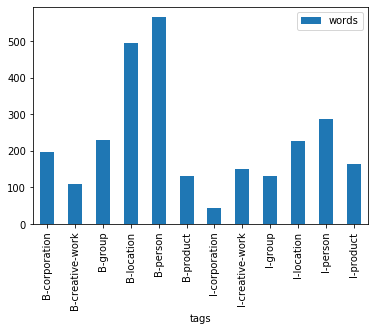

In [3]:
"""
12th index was O labels which were around 52k and I don't see their importance in the analysis because 
it's been removed while evaluating the model.
"""
tag_group = data.groupby('tags')
tag_count = tag_group.count()
tag_count = tag_count.drop(tag_count.index[12])
tag_count.plot(kind='bar')
plt.show()

### Feature Engineering

* In this dataset, each sentence is divided by a blank line in the text file which while inputting into a pandas dataframe is taken as NAN which is type float. Thus, to divide each sentence, I find floats and save the tokens above in one list. 
* For each sentence, I find the pos tags which are used as one of the features to train the model.
* The data sent becomes a list of list of list where the first list contains all the examples, the list within it contains each sentence and the list within it will contain tokens, pos tags and labels.

In [4]:
train = []
sent = []
tokens = []
labels = []
for d in train_data:
    if type(d[0]) == float:
        tags = nltk.pos_tag(tokens)
        for i, token in enumerate(tokens):
            sent.append([token, tags[i][1], labels[i]])
        train.append(sent)
        sent = []
        tokens = []
        labels = []
    else:
        tokens.append(d[0])
        labels.append(d[1]) 

train_sents, test_sents = train_test_split(train, test_size=0.2)

In [5]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [6]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 197 ms, sys: 20 ms, total: 217 ms
Wall time: 217 ms


In [7]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 9.12 s, sys: 62.9 ms, total: 9.18 s
Wall time: 9.2 s


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [8]:
y_pred = crf.predict(X_test)
labels = list(crf.classes_)
labels.remove('O') # remove 'O' label from evaluation
sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0])) # group B and I results
print(flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

NameError: name 'flat_classification_report' is not defined

### Question 2

It's a NER problem where each token in the sentence has to be classified in a certain tag, so at the end of the we have to use a classification model. Now, due to the time constraint, I opted to use the models which I have already used before.
I had two solutions in mind:

* NER using sklearn
* NER using spacy

Reason I used sklearn was because training data was formatted in IOB format. Spacy only uses BILOU format, thus I would have to write extra piece of code to convert IOB format into BILOU. 

According to the literature I have read, I believe BILOU formatted dataset provides more robust results than IOB, probably, because algorithm gets an idea where the last token of the label is present. For example my name Yashad Sanjay Samant will be formatted as Yashad (B), Sanjay (I) Samant (I) in IOB format while Yashad (B), Sanjay (I) Samant (L) in BILOU format. 

When I trained a NER model for address classifier last year, I trained it using both IOB and BILOU formatted dataset and I found BILOU dataset results to be better.

### Question 3: Right Metric

Right metric depends on the application and the data itself. In the above problem, I used **precision, recall and f1** due to following reasons:
* NER is a classification problem.
* Dataset is imbalanced. We get a good idea of how the model performs for each class when we use the metric.
* Implementing a confusion matrix becomes easier which can give you an indication of why and where a particular class has failed and we can improve the model next time.
* Easier to interpret.
* Quicker to implement.


